In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/PyTorch Notebooks/LeNet')
!pwd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/content/drive/MyDrive/Colab Notebooks/PyTorch Notebooks/LeNet


In [28]:
batch_size = 32
train_dataset = datasets.MNIST('/dataset',train=True,transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST('/dataset',train=False,transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
classes = train_dataset.classes

In [29]:
print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)
print(classes)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [30]:
train_data_iter = iter(train_loader)
images, labels = train_data_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [31]:
def train_image_show(images, labels):
  num_images = images.shape[0]
  fig, ax = plt.subplots(nrows= 1 if num_images<5 else int(np.ceil(num_images/4)), ncols = num_images if num_images<5 else 4, figsize=(10,10))
  if num_images<5:
    for i in range(num_images):
      ax[i].imshow(images[i].reshape(28,28),cmap='gray',interpolation='none')
      ax[i].axis('off')
      ax[i].set_title(classes[int(labels[i])])
  else:
    n = 0
    for i in range(int(np.ceil(num_images/4))):
      for j in range(4):
        if n<num_images:
          ax[i,j].imshow(images[n].reshape(28,28),cmap='gray',interpolation='none')
          ax[i,j].axis('off')
          ax[i,j].set_title(classes[int(labels[n])])
        else:
          fig.delaxes(ax[i,j])
        n=n+1
  plt.tight_layout(pad=1, h_pad=1, w_pad=1)
  plt.show()        

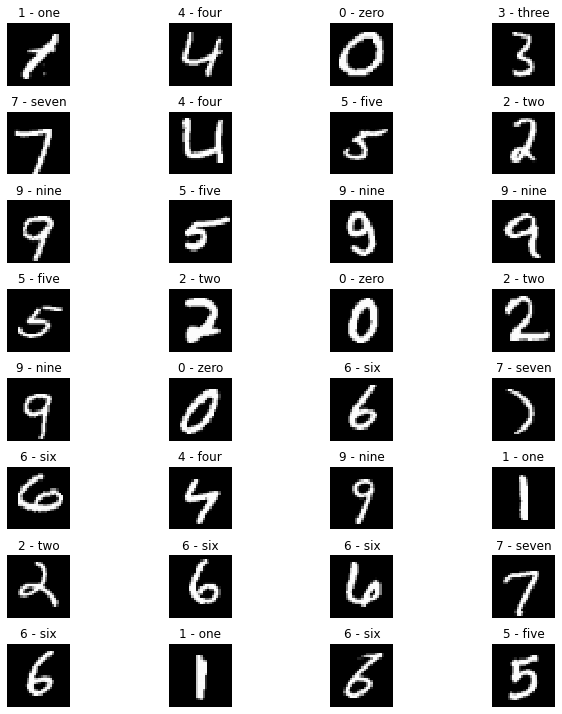

In [32]:
train_image_show(images, labels)

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

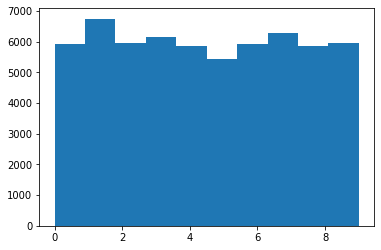

In [33]:
plt.hist(train_loader.dataset.targets)

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

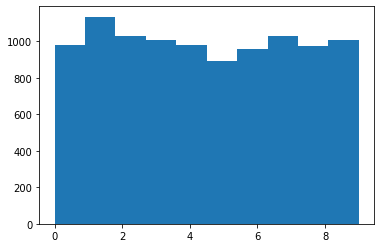

In [34]:
plt.hist(test_loader.dataset.targets)

In [46]:
class LeNet(nn.Module):
  def __init__(self, input_channel, num_classes):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(2,2))#((28+2*2-5)/1)+1=28
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(0,0))
    self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2), padding=(0,0))
    self.dense1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.dense2 = nn.Linear(in_features=120, out_features=84)
    self.dense3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, X):
    # print(X.shape)
    X = self.pool(torch.sigmoid(self.conv1(X)))#width and height = 28 => ((28+2*2-5)/1)+1=28 => ((28+2*2-5)/2)+1=14.5=14, channel = 1 => 6 => 6
    # print(X.shape)
    X = self.pool(torch.sigmoid(self.conv2(X)))#width and height = 14 => ((14+0*0-5)/1)+1=10 => ((10+2*2-5)/2)+1=5.5=5, channel = 6 => 16 => 16
    # print(X.shape)
    X = X.reshape(X.shape[0], -1)# in=5*5*16=400 out=120
    # print(X.shape)
    X = torch.sigmoid(self.dense1(X))# in=400 out=120
    # print(X.shape)
    X = torch.sigmoid(self.dense2(X))# in=120 out=84
    # print(X.shape)
    X = self.dense3(X)# in=84 out=10
    # print(X.shape)
    return X

In [66]:
model = LeNet(1,10).to(device)
_, preds = torch.max(model(torch.rand((32,1,28,28)).to(device)),1)
preds

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

In [67]:
learning_rate = .001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

In [68]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [77]:
dataloaders = {
    'train':train_loader,
    'val':test_loader
}
dataset_sizes = {
    'train':train_loader.dataset.data.shape[0],
    'val':test_loader.dataset.data.shape[0]
}
best_model_wts = train_model(model, criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0134 Acc: 0.9957
val Loss: 0.0389 Acc: 0.9896

Epoch 1/24
----------
train Loss: 0.0115 Acc: 0.9964
val Loss: 0.0381 Acc: 0.9892

Epoch 2/24
----------
train Loss: 0.0116 Acc: 0.9963
val Loss: 0.0436 Acc: 0.9871

Epoch 3/24
----------
train Loss: 0.0098 Acc: 0.9973
val Loss: 0.0438 Acc: 0.9875

Epoch 4/24
----------
train Loss: 0.0096 Acc: 0.9967
val Loss: 0.0410 Acc: 0.9885

Epoch 5/24
----------
train Loss: 0.0091 Acc: 0.9970
val Loss: 0.0387 Acc: 0.9889

Epoch 6/24
----------
train Loss: 0.0088 Acc: 0.9972
val Loss: 0.0447 Acc: 0.9891

Epoch 7/24
----------
train Loss: 0.0080 Acc: 0.9973
val Loss: 0.0486 Acc: 0.9869

Epoch 8/24
----------
train Loss: 0.0071 Acc: 0.9977
val Loss: 0.0453 Acc: 0.9890

Epoch 9/24
----------
train Loss: 0.0069 Acc: 0.9977
val Loss: 0.0424 Acc: 0.9887

Epoch 10/24
----------
train Loss: 0.0063 Acc: 0.9978
val Loss: 0.0504 Acc: 0.9872

Epoch 11/24
----------
train Loss: 0.0059 Acc: 0.9979
val Loss: 0.0515 Acc: 0.9866

Ep

In [86]:
def test_image_show(images, labels, preds):
  num_images = images.shape[0]
  fig, ax = plt.subplots(nrows= 1 if num_images<5 else int(np.ceil(num_images/4)), ncols = num_images if num_images<5 else 4, figsize=(10,10))
  if num_images<5:
    for i in range(num_images):
      ax[i].imshow(images[i].reshape(28,28),cmap='gray',interpolation='none')
      ax[i].axis('off')
      ax[i].set_title(classes[int(labels[i])]+"->"+classes[int(preds[i])])
  else:
    n = 0
    for i in range(int(np.ceil(num_images/4))):
      for j in range(4):
        if n<num_images:
          ax[i,j].imshow(images[n].reshape(28,28),cmap='gray',interpolation='none')
          ax[i,j].axis('off')
          ax[i,j].set_title(classes[int(labels[n])]+"->"+classes[int(preds[n])])
        else:
          fig.delaxes(ax[i,j])
        n=n+1
  plt.tight_layout(pad=1, h_pad=1, w_pad=1)
  plt.show() 

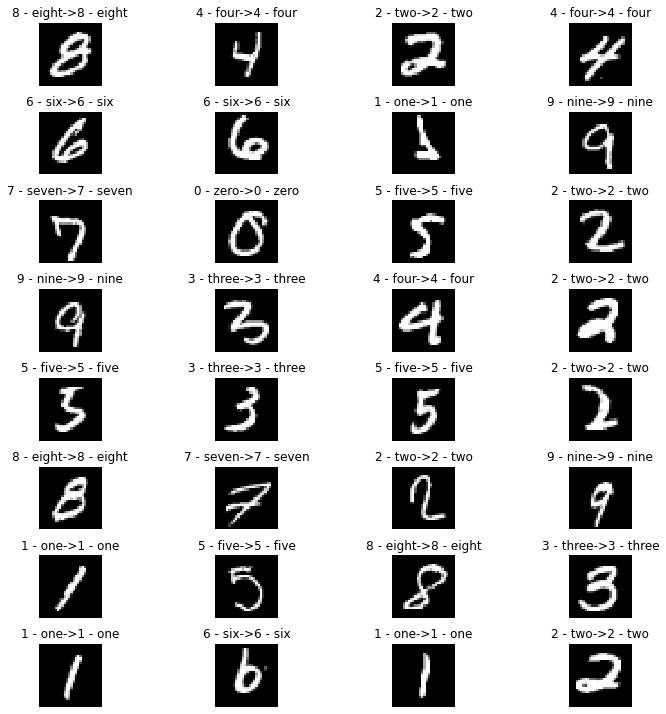

In [87]:
test_data_iter = iter(test_loader)
test_images, test_labels = test_data_iter.next()
model = best_model_wts
outputs = model(test_images.to(device))
_, preds = torch.max(outputs, 1)
# print(preds)
test_image_show(test_images,test_labels, preds)